In [216]:
import lib.notebook_helpers as nh
import baseline.estimators as estimators
import nncf.run_model_test as nn_test
from nncf.evaluate_recall import evaluate_model_recall
import os
import pickle
import scipy.sparse as sp
from nncf.evaluate_recall import get_preds
from importlib import reload
import numpy as np
import pandas as pd
import webbrowser
from IPython.display import display, Markdown
from IPython.core.display import SVG
from random import randint

TEST_PART_SIZE = 2000

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [67]:
def format_results_list(res_list, n=None):
    if n != None:
        res_list = res_list[:n]
    return '\n'.join([str(i+1) + ". " + item for i, item in enumerate(res_list)])

In [68]:
def get_ranked_list(y_preds, mlby):
    return [
        [mlby.inverse_transform(np.expand_dims(onehot_usertag, axis=0))[0][0] for onehot_usertag in ranked_list]
        for ranked_list in y_preds
    ]

## Load dataset:

In [5]:
test_set_path = os.path.join('data/test_tag_dataset.pkl')
with open(test_set_path, 'rb') as f:
    X, y, mlbx, mlby, val_y, test_y = pickle.load(f)
    y = y.tocsr()
    X = sp.csr_matrix(X)
    test_y = test_y.toarray()
id_mapping = pd.read_pickle('data/index_id_mapping.pkl')

# Tag recommender system

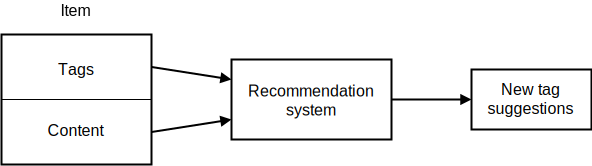

In [2]:
SVG(filename='/Users/davidmalmstrom/Documents/proj/figures/general_tag_rec2.svg')

### Flickr dataset

In [208]:
index = randint(0, len(test_y) - 1)
user_tags = mlby.inverse_transform(y)[index] + mlby.inverse_transform(test_y)[index]
autotags = mlbx.inverse_transform(X)[index]
display(Markdown('Item user-tags: ' + ', '.join(user_tags)))
display(Markdown('Item autotags: ' + ', '.join(autotags)))

Item user-tags: california, colour, jpg, photograph, color, jpeg, photo, travel

Item autotags: arbor, architecture, building, country house, gable, house, manor, mansion, outdoor, pediment, porch, portico, villa

In [206]:
url = 'https://' + 'www.flickr.com/' + id_mapping.loc[index]['user+id']
webbrowser.open(url);

## Train base model and make predictions

In [102]:
base_model = estimators.BaselineModel(factors=1000,
                                regularization=7,
                                iterations=15,
                                show_progress=False,
                                n=10,
                                content_scale_factor=0.038,
                                alpha=3.5)

In [103]:
base_model.fit(X, y);

BaselineModel(alpha=3.5, content_scale_factor=0.038, factors=1000,
              filter_seen=True, iterations=15, n=10, regularization=7,
              show_progress=False)

In [105]:
y_pred_base = base_model.predict(X[:TEST_PART_SIZE], start_index=0, rank_list=True)
y_pred_base_ranked = get_ranked_list(y_pred_base, mlby)

## Load pretrained nn model and make predictions

In [101]:
nn_model_runfile_path = "nncf/runs/past_runs/runza/runza14.yml"

params = nn_test.read_params(nn_model_runfile_path)

nn_model = nn_test.build_model(params, y.shape, X.shape[1])

In [24]:
y_pred_nn = get_preds(nn_model, y[:TEST_PART_SIZE], 10, False, 0, X[:TEST_PART_SIZE].toarray(), rank_list=True)
y_pred_nn_ranked = get_ranked_list(y_pred_nn, mlby)

## Check results

In [233]:
index = randint(0, len(test_y) - 1)
display(Markdown('**Item user-tags: ' + ', '.join(mlby.inverse_transform(y)[index]) + '**'))
display(Markdown('Item autotags: ' + ', '.join(mlbx.inverse_transform(X)[index])))

**Item user-tags: blues, chicago, house, lake, park, river**

Item autotags: architecture, building, building complex, city, freeway, highway, intersection, outdoor, road, skyline, skyscraper, tower, truck, vehicle, water, waterfront

In [234]:
pred_goal_list = mlby.inverse_transform(test_y)[index]
display(Markdown('Prediction goal: \n * ' + ' \n * '.join(pred_goal_list)))


Prediction goal: 
 * cars 
 * city 
 * garage 
 * illinois 
 * statue 
 * tourists

In [235]:
display(Markdown('Baseline model predicted: \n' + format_results_list(y_pred_base_ranked[index], 5)))

Baseline model predicted: 
1. illinois
2. national
3. highway
4. road
5. shield

In [236]:
display(Markdown('Deep learning model predicted: \n' + format_results_list(y_pred_nn_ranked[index], 5) ))

Deep learning model predicted: 
1. illinois
2. water
3. michigan
4. pond
5. il

In [238]:
url = 'https://' + 'www.flickr.com/' + id_mapping.loc[index]['user+id']
webbrowser.open(url);

In [87]:
test_both(test_y, y_pred_base, y_pred_nn, mlbx, mlby, y, X, index=1532)

Start user tags: ('cars', 'course', 'france', 'pentax', 'race', 'sport')
Start autotags: ('car', 'car bumper', 'car hood', 'car part', 'car tire', 'ferrari', 'outdoor', 'sports car', 'tire', 'truck', 'van', 'vehicle')

Pred goal: ('12', 'car', 'june', 'le', 'racing', 'sunday', 'voiture')

Base model predicted: ['paris', 'racing', 'action', 'run', 'competition', 'running', 'car', 'justpentax', 'francia', 'french']

NN model predicted: ['car', 'auto', 'paris', 'sports', 'racing', 'voiture', 'blanc', 'motorsport', 'bike', 'automobile']


In [91]:
test_both(test_y, y_pred_base, y_pred_nn, mlbx, mlby, y, X, index=1532)

Start user tags: ('cars', 'course', 'france', 'pentax', 'race', 'sport')
Start autotags: ('car', 'car bumper', 'car hood', 'car part', 'car tire', 'ferrari', 'outdoor', 'sports car', 'tire', 'truck', 'van', 'vehicle')

Pred goal: ('12', 'car', 'june', 'le', 'racing', 'sunday', 'voiture')

Base model predicted: ['paris', 'racing', 'action', 'run', 'competition', 'running', 'car', 'justpentax', 'francia', 'french']

NN model predicted: ['car', 'auto', 'paris']


In [23]:
print("NN model predicted: " + str(y_pred_nn_ranked[index]))

NN model predicted: ['massachusetts', 'japan', 'retro']


In [15]:
test_both(test_y, y_pred_base, y_pred_nn, mlbx, mlby, y, X)

96
Start user tags: ('francisco', 'garden', 'la', 'street')
Start autotags: ('birdbath', 'garden', 'nature', 'outdoor', 'plant', 'potted plant')

Pred goal: ('january', 'playa', 'san')

Base model predicted: ('los', 'los+angeles', 'san')

NN model predicted: ('city', 'los', 'san')


In [90]:
def test_both(test_y, y_pred_base, y_pred_nn, mlbx, mlby, y, X, index=None):
    if index is None:
        index = randint(0, len(test_y) - 1)
        print(index)
    
    print("Start user tags: " + str(mlby.inverse_transform(y)[index]))
    print("Start autotags: " + str(mlbx.inverse_transform(X)[index]))
    print("")
    print("Pred goal: " + str(mlby.inverse_transform(test_y)[index]))
    print("")
    #print("Base model predicted: " + str(mlby.inverse_transform(y_pred_base)[index]))
    print("Base model predicted: " + str(qwe[index]))
    print("")
    #print("NN model predicted: " + str(mlby.inverse_transform(y_pred_nn)[index]))
    print("NN model predicted: " + str(asd2[index]))

    
    url = 'https://' + 'www.flickr.com/' + id_mapping.loc[index]['user+id']
    webbrowser.open(url)